In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import json

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.decomposition import TruncatedSVD, PCA
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

# Encontrar el codo
from kneed import KneeLocator
from scipy.sparse import hstack

from ipywidgets import interact, widgets

In [5]:
file_path = "JupiterNotebook/datos/movies.dat"
movies = pd.read_csv(file_path, sep="\t", engine="python", header=0, encoding="ISO-8859-1",
                     names=["MovieID", "Title", "imdbID", "spanishTitle", "imdbPictureURL", "year",
                            "rtID", "rtAllCriticsRating", "rtAllCriticsNumReviews", "rtAllCriticsNumFresh",
                            "rtAllCriticsNumRotten", "rtAllCriticsScore", "rtTopCriticsRating", "rtTopCriticsNumReviews",
                            "rtTopCriticsNumFresh", "rtTopCriticsNumRotten", "rtTopCriticsScore", "rtAudienceRating",
                            "rtAudienceNumRatings", "rtAudienceScore", "rtPictureURL"])

In [6]:
movies

,MovieID,Title,imdbID,spanishTitle,imdbPictureURL,year,rtID,rtAllCriticsRating,rtAllCriticsNumReviews,rtAllCriticsNumFresh,...,rtAllCriticsScore,rtTopCriticsRating,rtTopCriticsNumReviews,rtTopCriticsNumFresh,rtTopCriticsNumRotten,rtTopCriticsScore,rtAudienceRating,rtAudienceNumRatings,rtAudienceScore,rtPictureURL
0,1,Toy story,114709,Toy story (juguetes),http://ia.media-imdb.com/images/M/MV5BMTMwNDU0...,1995,toy_story,9,73,73,...,100,8.5,17,17,0,100,3.7,102338,81,http://content7.flixster.com/movie/10/93/63/10...
1,2,Jumanji,113497,Jumanji,http://ia.media-imdb.com/images/M/MV5BMzM5NjE1...,1995,1068044-jumanji,5.6,28,13,...,46,5.8,5,2,3,40,3.2,44587,61,http://content8.flixster.com/movie/56/79/73/56...
2,3,Grumpy Old Men,107050,Dos viejos gruñones,http://ia.media-imdb.com/images/M/MV5BMTI5MTgy...,1993,grumpy_old_men,5.9,36,24,...,66,7,6,5,1,83,3.2,10489,66,http://content6.flixster.com/movie/25/60/25602...
3,4,Waiting to Exhale,114885,Esperando un respiro,http://ia.media-imdb.com/images/M/MV5BMTczMTMy...,1995,waiting_to_exhale,5.6,25,14,...,56,5.5,11,5,6,45,3.3,5666,79,http://content9.flixster.com/movie/10/94/17/10...
4,5,Father of the Bride Part II,113041,Vuelve el padre de la novia (Ahora también abu...,http://ia.media-imdb.com/images/M/MV5BMTg1NDc2...,1995,father_of_the_bride_part_ii,5.3,19,9,...,47,5.4,5,1,4,20,3,13761,64,http://content8.flixster.com/movie/25/54/25542...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10192,65088,Bedtime Stories,960731,Más allá de los sueños,http://ia.media-imdb.com/images/M/MV5BMjA5Njk5...,2008,bedtime_stories,4.4,104,26,...,25,4.7,26,6,20,23,3.5,108877,63,http://content6.flixster.com/movie/10/94/33/10...
10193,65091,Manhattan Melodrama,25464,El enemigo público número 1,http://ia.media-imdb.com/images/M/MV5BMTUyODE3...,1934,manhattan_melodrama,7,12,10,...,83,0,4,2,2,50,3.7,344,71,http://content9.flixster.com/movie/66/44/64/66...
10194,65126,Choke,1024715,Choke,http://ia.media-imdb.com/images/M/MV5BMTMxMDI4...,2008,choke,5.6,135,73,...,54,4.9,26,8,18,30,3.3,13893,55,http://content6.flixster.com/movie/10/85/09/10...
10195,65130,Revolutionary Road,959337,Revolutionary Road,http://ia.media-imdb.com/images/M/MV5BMTI2MzY2...,2008,revolutionary_road,6.7,194,133,...,68,6.9,36,25,11,69,3.5,46044,70,http://content8.flixster.com/movie/10/88/40/10...


In [35]:
# Crear una copia del DataFrame para evitar el SettingWithCopyWarning
movies_cleaned = movies.copy()

In [36]:
#Devolver una tupla que contiene el número de filas y el número de columnas en el DataFrame.
movies_cleaned.shape

(9967, 21)

In [37]:
movies_cleaned.columns

Index(['MovieID', 'Title', 'imdbID', 'spanishTitle', 'imdbPictureURL', 'year',
       'rtID', 'rtAllCriticsRating', 'rtAllCriticsNumReviews',
       'rtAllCriticsNumFresh', 'rtAllCriticsNumRotten', 'rtAllCriticsScore',
       'rtTopCriticsRating', 'rtTopCriticsNumReviews', 'rtTopCriticsNumFresh',
       'rtTopCriticsNumRotten', 'rtTopCriticsScore', 'rtAudienceRating',
       'rtAudienceNumRatings', 'rtAudienceScore', 'rtPictureURL'],
      dtype='object')

In [38]:
# Visualizar las primeras filas para asegurarnos de que se haya cargado correctamente
movies_cleaned.head()

,MovieID,Title,imdbID,spanishTitle,imdbPictureURL,year,rtID,rtAllCriticsRating,rtAllCriticsNumReviews,rtAllCriticsNumFresh,...,rtAllCriticsScore,rtTopCriticsRating,rtTopCriticsNumReviews,rtTopCriticsNumFresh,rtTopCriticsNumRotten,rtTopCriticsScore,rtAudienceRating,rtAudienceNumRatings,rtAudienceScore,rtPictureURL
0,1,Toy story,114709,Toy story (juguetes),http://ia.media-imdb.com/images/M/MV5BMTMwNDU0...,1995,toy_story,9.0,73,73,...,100,8.5,17,17,0,100,3.7,102338,81,http://content7.flixster.com/movie/10/93/63/10...
1,2,Jumanji,113497,Jumanji,http://ia.media-imdb.com/images/M/MV5BMzM5NjE1...,1995,1068044-jumanji,5.6,28,13,...,46,5.8,5,2,3,40,3.2,44587,61,http://content8.flixster.com/movie/56/79/73/56...
2,3,Grumpy Old Men,107050,Dos viejos gruñones,http://ia.media-imdb.com/images/M/MV5BMTI5MTgy...,1993,grumpy_old_men,5.9,36,24,...,66,7,6,5,1,83,3.2,10489,66,http://content6.flixster.com/movie/25/60/25602...
3,4,Waiting to Exhale,114885,Esperando un respiro,http://ia.media-imdb.com/images/M/MV5BMTczMTMy...,1995,waiting_to_exhale,5.6,25,14,...,56,5.5,11,5,6,45,3.3,5666,79,http://content9.flixster.com/movie/10/94/17/10...
4,5,Father of the Bride Part II,113041,Vuelve el padre de la novia (Ahora también abu...,http://ia.media-imdb.com/images/M/MV5BMTg1NDc2...,1995,father_of_the_bride_part_ii,5.3,19,9,...,47,5.4,5,1,4,20,3,13761,64,http://content8.flixster.com/movie/25/54/25542...


In [39]:
movies_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9967 entries, 0 to 10196
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   MovieID                 9967 non-null   int64  
 1   Title                   9967 non-null   object 
 2   imdbID                  9967 non-null   int64  
 3   spanishTitle            9967 non-null   object 
 4   imdbPictureURL          9811 non-null   object 
 5   year                    9967 non-null   int64  
 6   rtID                    9886 non-null   object 
 7   rtAllCriticsRating      9967 non-null   float64
 8   rtAllCriticsNumReviews  9967 non-null   Int64  
 9   rtAllCriticsNumFresh    9967 non-null   object 
 10  rtAllCriticsNumRotten   9967 non-null   object 
 11  rtAllCriticsScore       9967 non-null   object 
 12  rtTopCriticsRating      9967 non-null   object 
 13  rtTopCriticsNumReviews  9967 non-null   object 
 14  rtTopCriticsNumFresh    9967 non-null  

In [41]:
movies_cleaned.describe(include="object")

,Title,spanishTitle,imdbPictureURL,rtID,rtAllCriticsNumFresh,rtAllCriticsNumRotten,rtAllCriticsScore,rtTopCriticsRating,rtTopCriticsNumReviews,rtTopCriticsNumFresh,rtTopCriticsNumRotten,rtTopCriticsScore,rtAudienceRating,rtAudienceNumRatings,rtAudienceScore,rtPictureURL
count,9967,9967,9811,9886,9967,9967,9967,9967,9967,9967,9967,9967,9967,9967,9967,9967
unique,9188,9142,9026,9134,204,149,100,81,48,43,38,97,33,5086,88,9151
top,Hamlet,Hamlet,http://ia.media-imdb.com/images/M/MV5BMTc1MzQ0...,1075422-hamlet,0,0,0,0,0,0,0,0,0,0,0,http://images.rottentomatoescdn.com/images/def...
freq,6,6,6,6,1050,1555,1053,5305,2461,3530,3951,3530,2622,2622,2625,57


In [12]:
movies_cleaned.isnull().sum()

MovieID                     0
Title                       0
imdbID                      0
spanishTitle                0
imdbPictureURL            181
year                        0
rtID                      311
rtAllCriticsRating          0
rtAllCriticsNumReviews      0
rtAllCriticsNumFresh        0
rtAllCriticsNumRotten       0
rtAllCriticsScore           0
rtTopCriticsRating          0
rtTopCriticsNumReviews      0
rtTopCriticsNumFresh        0
rtTopCriticsNumRotten       0
rtTopCriticsScore           0
rtAudienceRating            0
rtAudienceNumRatings        0
rtAudienceScore             0
rtPictureURL                0
dtype: int64

Solo tenemos nulos en las columnas de imdbPictureURL y rtID

In [13]:
movies.rtID.value_counts()

1075422-hamlet                              6
phantom_of_the_opera                        5
doa_dead_or_alive                           4
august_rush                                 4
1010678-invasion_of_the_body_snatchers      4
                                           ..
halloween_5_the_revenge_of_michael_myers    1
antitrust                                   1
romy_and_micheles_high_school_reunion       1
murderball                                  1
saddest_music_in_the_world                  1
Name: rtID, Length: 9134, dtype: int64

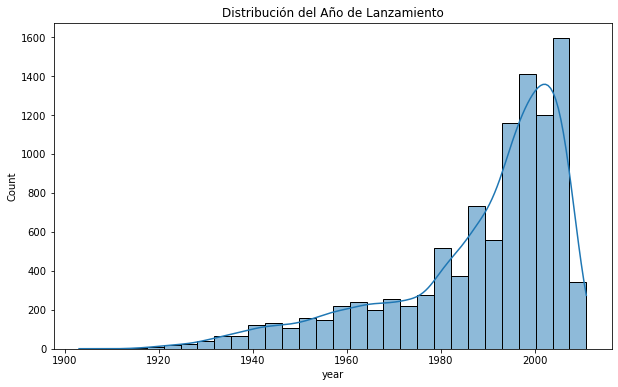

In [14]:
# Visualizar la distribución de algunas variables
plt.figure(figsize=(10, 6))
sns.histplot(movies['year'], bins=30, kde=True)
plt.title('Distribución del Año de Lanzamiento')
plt.show()

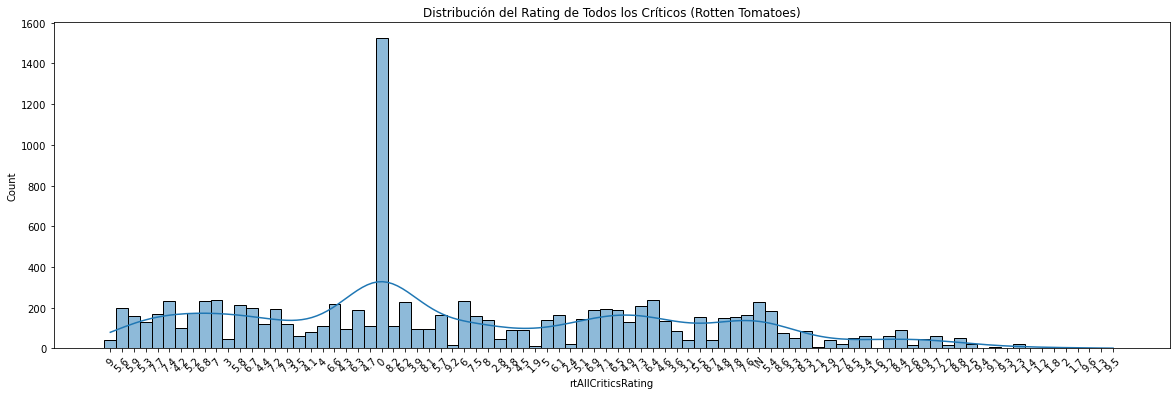

In [15]:
# Distribución del rating de todos los críticos (Rotten Tomatoes) con ajustes en el eje X
plt.figure(figsize=(20, 6))
sns.histplot(movies['rtAllCriticsRating'], bins=30, kde=True)
plt.title('Distribución del Rating de Todos los Críticos (Rotten Tomatoes)')
plt.xticks(rotation=45)  # Inclinar las etiquetas del eje X 45 grados
plt.show()

Vamos a convertir las variables de tipo rating o score a numericas. Las que tengan valores de \N lo convierte a null

In [16]:
print(movies['rtAllCriticsRating'].dtype)

object


In [17]:
movies['rtAllCriticsRating'] = pd.to_numeric(movies['rtAllCriticsRating'], errors='coerce')

In [18]:
print(movies['rtAllCriticsRating'].dtype)


float64


In [19]:
print(movies['rtAllCriticsRating'].head())

0    9.0
1    5.6
2    5.9
3    5.6
4    5.3
Name: rtAllCriticsRating, dtype: float64


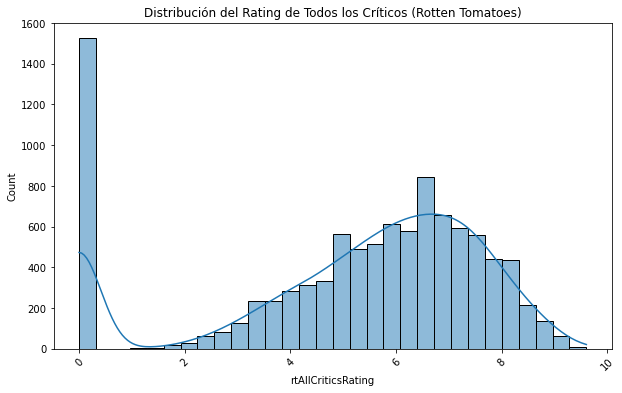

In [20]:
# Distribución del rating de todos los críticos (Rotten Tomatoes) con ajustes en el eje X
plt.figure(figsize=(10, 6))
sns.histplot(movies['rtAllCriticsRating'], bins=30, kde=True)
plt.title('Distribución del Rating de Todos los Críticos (Rotten Tomatoes)')
plt.xticks(rotation=45)  # Inclinar las etiquetas del eje X 45 grados
plt.show()

In [21]:
movies.dtypes

MovieID                     int64
Title                      object
imdbID                      int64
spanishTitle               object
imdbPictureURL             object
year                        int64
rtID                       object
rtAllCriticsRating        float64
rtAllCriticsNumReviews     object
rtAllCriticsNumFresh       object
rtAllCriticsNumRotten      object
rtAllCriticsScore          object
rtTopCriticsRating         object
rtTopCriticsNumReviews     object
rtTopCriticsNumFresh       object
rtTopCriticsNumRotten      object
rtTopCriticsScore          object
rtAudienceRating           object
rtAudienceNumRatings       object
rtAudienceScore            object
rtPictureURL               object
dtype: object

In [22]:
movies['rtAllCriticsRating'] = pd.to_numeric(movies['rtAllCriticsRating'], errors='coerce')

In [23]:
movies.rtAllCriticsNumReviews.value_counts()

0      655
5      285
7      279
6      268
9      258
      ... 
222      1
218      1
262      1
219      1
275      1
Name: rtAllCriticsNumReviews, Length: 244, dtype: int64

In [24]:
movies['rtAllCriticsNumReviews'] = pd.to_numeric(movies['rtAllCriticsNumReviews'], errors='coerce')

In [25]:
movies.dtypes

MovieID                     int64
Title                      object
imdbID                      int64
spanishTitle               object
imdbPictureURL             object
year                        int64
rtID                       object
rtAllCriticsRating        float64
rtAllCriticsNumReviews    float64
rtAllCriticsNumFresh       object
rtAllCriticsNumRotten      object
rtAllCriticsScore          object
rtTopCriticsRating         object
rtTopCriticsNumReviews     object
rtTopCriticsNumFresh       object
rtTopCriticsNumRotten      object
rtTopCriticsScore          object
rtAudienceRating           object
rtAudienceNumRatings       object
rtAudienceScore            object
rtPictureURL               object
dtype: object

In [34]:
# Eliminar filas con NaN en la columna 'rtAllCriticsNumReviews'
movies['rtAllCriticsNumReviews'] = movies['rtAllCriticsNumReviews'].astype('Int64')

<ipython-input-34-a3199358cfac>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies['rtAllCriticsNumReviews'] = movies['rtAllCriticsNumReviews'].astype('Int64')


In [30]:
print(movies['rtAllCriticsNumReviews'].dtype)

Int64


TypeError: No loop matching the specified signature and casting was found for ufunc add

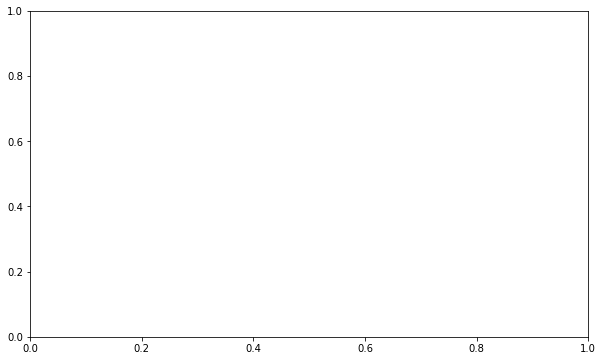

In [31]:
# Distribución del rating de todos los críticos (Rotten Tomatoes) con ajustes en el eje X
plt.figure(figsize=(10, 6))
sns.histplot(movies['rtAllCriticsNumReviews'], bins=30, kde=True)
plt.title('Distribución del Número de reviews de Todos los Críticos (Rotten Tomatoes)')
plt.xticks(rotation=45)  # Inclinar las etiquetas del eje X 45 grados
plt.show()